# 0. Load Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import models
import utils
from matplotlib import pyplot as plt
from classes import  Locatable, Satellite, Cluster, Vehicle
from drawingmap import DrawingMap

# 1. Load Data

## 1.1. Satellites

In [2]:
satellites, df_satellites = utils.LoadingData.load_satellites(DEBUG=False)
print(f'Cantidad de satellites cargados: {len(satellites)}')

Cantidad de satellites cargados: 9


## 1.2. Customer Clusters

In [3]:
clusters, df_clusters = utils.LoadingData.load_customer_clusters(DEBUG=False)
print(f'Cantidad de clusters cargados: {len(clusters)}')

Cantidad de clusters cargados: 721


## 1.3. Load Vehicles

In [4]:
small_vehicle = Vehicle(id='small'
                        , type='small'
                        , capacity=115
                        , costFixed=2
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0072
                        , time_dispatch=0.625
                        , speed_line=40
                        , Tmax=12
                        , k=1.3)
large_vehicle = Vehicle(id='large'
                        , type='large'
                        , capacity=456
                        , costFixed=8
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0142
                        , time_dispatch=0.75
                        , speed_line=40
                        , Tmax=12
                        , k=1.3)

## 1.4. Load Matrixes: Distance and Durations with and without traffic

### 1.4.1. From Satellites to Clusters

In [5]:
matrixes_from_satellites = utils.LoadingData.load_distances_duration_matrix_from_satellite()

### 1.4.2. From DC to Clusters

In [6]:
matrixes_from_dc = utils.LoadingData.load_distances_duration_matrix_from_dc()

# 2. Drawing Map

## 2.1. La Paz with customer segments

In [7]:
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)

drawer = DrawingMap(location_la_paz)

drawer.addNodes(list_locatables=list(clusters.values()), color="blue", radius=1)
drawer.addNodes(list_locatables=list(satellites.values()), color='red', radius=3)
drawer.addMarker(location=location_DC, label='DC')

map = drawer.viewMap()
map

# 3. Generate Params

In [8]:
periods = 12

params_gurobi = {
    'TimeLimit':3600,
    'MIPGap':0.00
}

## 3.1. Average Fleet Size
#### a) From Satellite to Customer Cluster

In [9]:
config_ = utils.ConfigDeterministic()
fleet_size_satellites = config_.calculate_avg_fleet_size_from_satellites(satellites=list(satellites.values())
                                                                         , clusters=list(clusters.values())
                                                                         , vehicle=small_vehicle
                                                                         ,periods=periods, distances_linehaul=matrixes_from_satellites['distance'])

#### b) From DC to Customer Cluster

In [10]:
fleet_size_dc = config_.calculate_avg_fleet_size_from_dc(clusters=clusters.values(), vehicle=large_vehicle, periods=periods
                                                         , distances_linehaul=matrixes_from_dc['distance'])

In [11]:
fleet_size_required = {
    'small': fleet_size_satellites,
    'large': fleet_size_dc
}

## 3.3. Cost *$c_{sk}^{t}$* and *$g_{k}{t}$*

In [12]:
distance_average_from_satellites = {}
for s in satellites.values():
    sum_distances = 0
    count_records = 0
    for k in clusters.values():
        sum_distances+=matrixes_from_satellites['distance'][(s.id, k.id)]
        count_records=count_records+1
    avg_distance = sum_distances/count_records
    distance_average_from_satellites[s.id] = avg_distance
distance_average_from_satellites

{'Abaroa': 7.163305131761442,
 'Llojeta': 9.200861303744794,
 'Cota Cota': 10.82359778085992,
 'Achachicala': 8.87314285714286,
 'Mallasa': 12.356907073509012,
 'Sopocachi': 7.580083217753125,
 'Perferica': 8.806714285714287,
 'Zona Cementerio': 9.16176976421637,
 'Los Pinos': 8.961859916782249}

In [13]:
distance_average_from_dc = 0
sum_distances = 0
count_records = 0
for k in clusters.values():
    sum_distances+=matrixes_from_dc['distance'][k.id]
    count_records=count_records+1
avg_distance = sum_distances/count_records
distance_average_from_dc = avg_distance
distance_average_from_dc

18.852235783633862

In [14]:
# cost of shipping
fee_cost_from_satellites = 0.071 #0.071
fee_cost_from_dc = 0.06 #0.06 #

cost_shipping_from_satellites = dict([
    ((s.id, k.id),fee_cost_from_satellites*matrixes_from_satellites['distance'][(s.id, k.id)]/distance_average_from_satellites[s.id])
    if matrixes_from_satellites['distance'][(s.id, k.id)]/distance_average_from_satellites[s.id] > 0.5 else ((s.id, k.id),fee_cost_from_satellites*0.5)
    for s in satellites.values() for k in clusters.values()
])


cost_shipping_from_dc = dict([
    ((k.id),fee_cost_from_dc*matrixes_from_dc['distance'][k.id]/distance_average_from_dc)
    if matrixes_from_dc['distance'][k.id]/distance_average_from_dc> 0.5 else ((k.id),fee_cost_from_dc*0.5)
    for k in clusters.values()
])

In [15]:
def cost_satellite_cluster_period(satellites: list[Satellite],
                                  clusters: list[Cluster],
                                  cost_shipping: dict[(str, str), float],
                                  vehicle_small: Vehicle,
                                  periods: int,
                                  vehicles_required: dict[str, dict]) -> dict[(str,str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            for s in satellites:
                costs[(s.id, k.id, t)] = (s.costSourcing*k.demandByPeriod[t]) + (cost_shipping[(s.id, k.id)]*k.demandByPeriod[t]) + \
                                         (vehicle_small.costFixed*vehicles_required['small'][(s.id, k.id, t)]['fleet_size'])
    return costs

def cost_dc_cluster_period(clusters: list[Cluster],
                           cost_shipping: dict[str, float],
                           vehicle_large: Vehicle,
                           periods: int,
                           vehicles_required: dict[str, dict]) -> dict[(str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            costs[(k.id, t)] = (cost_shipping[k.id] * k.demandByPeriod[t]) + (vehicle_large.costFixed * vehicles_required['large'][(k.id, t)]['fleet_size'])
    return costs

In [16]:
cost_C = cost_satellite_cluster_period(satellites.values(), clusters.values()
                                       ,cost_shipping=cost_shipping_from_satellites
                                       ,vehicle_small=small_vehicle
                                       ,periods=periods
                                       ,vehicles_required=fleet_size_required)

cost_G = cost_dc_cluster_period(clusters.values()
                                ,cost_shipping=cost_shipping_from_dc
                                ,vehicle_large=large_vehicle
                                ,periods=periods
                                ,vehicles_required=fleet_size_required)
cost_operation = {
    'satellite': cost_C,
    'dc': cost_G
}

max: 46.66019484083976 - min: 0.0979201183569459 - mean 1.4488937540859022


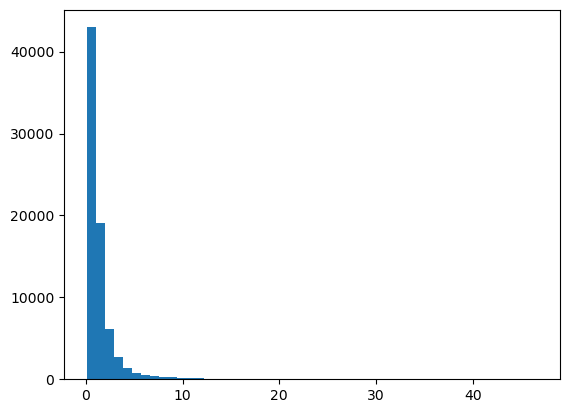

In [17]:
cost_shipping_satellites = [item for item in list(cost_C.values()) if item!=0]
print(f'max: {np.max(cost_shipping_satellites)} - min: {np.min(cost_shipping_satellites)} - mean {np.mean(cost_shipping_satellites)}')
plt.hist(cost_shipping_satellites, bins=50)
plt.show()

max: 18.055468973899767 - min: 0.04233331185551065 - mean 0.7030315197979999


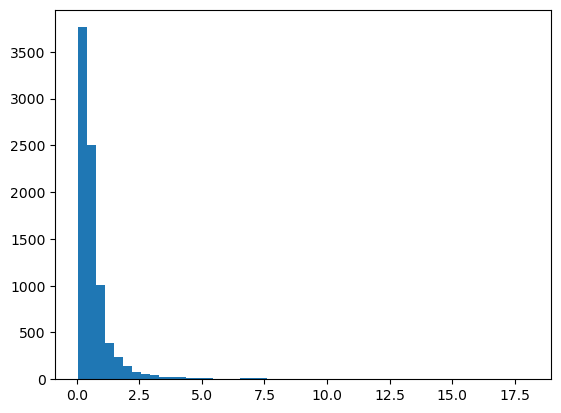

In [18]:
cost_shipping_dc = [item for item in list(cost_G.values()) if item!=0]
print(f'max: {np.max(cost_shipping_dc)} - min: {np.min(cost_shipping_dc)} - mean {np.mean(cost_shipping_dc)}')
plt.hist(cost_shipping_dc, bins=50)
plt.show()

# 4. Model Deterministic

In [19]:
model_ = models.ModelDeterministic(periods=periods)
model_.setParams(params=params_gurobi)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-13
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0


In [20]:
model_.build(satellites=list(satellites.values())
             ,clusters=list(clusters.values())
             ,vehicles_required=fleet_size_required
             ,costs=cost_operation)

Discarded solution information
add constraint de WALDO


{'time_building': 1}

In [21]:
print(model_.optimizeModel())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 86865 rows, 86682 columns and 403504 nonzeros
Model fingerprint: 0x94c86e62
Variable types: 0 continuous, 86682 integer (86682 binary)
Coefficient statistics:
  Matrix range     [1e-03, 2e+02]
  Objective range  [4e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 22133.351836
Presolve removed 2540 rows and 10848 columns
Presolve time: 0.38s
Presolved: 84325 rows, 75834 columns, 303768 nonzeros
Found heuristic solution: objective 18497.364727
Variable types: 0 continuous, 75834 integer (75834 binary)
Found heuristic solution: objective 17327.917743
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.144980e+04, 3496

In [22]:
cost_allocation_satellites = np.sum([
    (s.costFixed[q_id]/30) * model_.Y[(s.id, q_id)].x for s in list(satellites.values()) for q_id in s.capacity.keys()
])

cost_operating_satellites = np.sum([
    (s.costOperation[t]/30) * model_.X[(s.id, t)].x for s in list(satellites.values()) for t in range(periods)
])

cost_served_from_satellite = np.sum([
    cost_operation['satellite'][(s.id, k.id, t)] * model_.Z[(s.id, k.id, t)].x for s in list(satellites.values()) for k in
    list(clusters.values()) for t in
    range(periods)
])

cost_served_from_dc = np.sum([
    cost_operation['dc'][(k.id, t)] * model_.W[(k.id, t)].x for k in list(clusters.values()) for t in range(periods)
])

In [23]:
cost_allocation_satellites

333.33333333333337

In [24]:
cost_operating_satellites

1355.8333333333333

In [25]:
cost_served_from_satellite

9764.583873358215

In [26]:
cost_served_from_dc

0.0

## 4.1. Get results

In [27]:
variables_results = model_.get_results(satellites=list(satellites.values())
                                      ,clusters=list(clusters.values()))

### 4.1.1. Y

In [28]:
for k, v in variables_results['Y'].items():
    print(f'id: {v.id} cap: {k[1]}')

id: Cota Cota cap: 3
id: Achachicala cap: 5
id: Los Pinos cap: 3


### 4.1.2. X

In [29]:
for t in range(periods):
    print(f'###### t - {t}', end=" ")
    for k, v in variables_results['X'][t].items():
        print(f'id: {v.id}', end=" | ")
    print("")

###### t - 0 id: Achachicala | id: Los Pinos | 
###### t - 1 id: Achachicala | id: Los Pinos | 
###### t - 2 id: Cota Cota | id: Achachicala | 
###### t - 3 id: Achachicala | id: Los Pinos | 
###### t - 4 id: Achachicala | id: Los Pinos | 
###### t - 5 id: Cota Cota | id: Achachicala | 
###### t - 6 id: Achachicala | id: Los Pinos | 
###### t - 7 id: Cota Cota | id: Achachicala | 
###### t - 8 id: Achachicala | id: Los Pinos | 
###### t - 9 id: Achachicala | id: Los Pinos | 
###### t - 10 id: Achachicala | id: Los Pinos | 
###### t - 11 id: Cota Cota | id: Achachicala | 


### 4.1.3. W

In [30]:
period_selected = 10
lista_clusters = variables_results['W'][period_selected]

# map
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
drawer.addNodes(list_locatables=lista_clusters, color="blue", radius=3)
drawer.addMarker(location=location_DC, label='DC')
map = drawer.viewMap()
map

### 4.1.4 Z

In [31]:
map_colors = {
    'Abaroa': 'blue',
    'Llojeta': 'green',
    'Cota Cota': 'orange',
    'Achachicala': 'darkgreen',
    'Mallasa': 'black',
    'Sopocachi': 'gray',
    'Perferica': 'darkred',
    'Zona Cementerio': 'pink',
    'Los Pinos': 'purple'
}

In [32]:
period_selected = 11
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
for k, v in map_colors.items():
    satellite_selected = k
    lista_clusters = variables_results['Z'][period_selected][satellite_selected]
    if len(lista_clusters) == 0:
        continue
    # map
    drawer.addNodes(list_locatables=lista_clusters, color=v, radius=3)
    #drawer.addNode(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), color=v, radius=4)
    drawer.addMarker(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), label=satellite_selected)

drawer.addMarker(location=location_DC, label='DC')
map = drawer.viewMap()
map

In [33]:
#period_selected = 1
#satellite_selected = "Abaroa"
#lista_clusters = variables_results['Z'][period_selected][satellite_selected]
## map
#location_la_paz = (-16.501457, -68.149887)
#location_DC = (-16.5354544, -68.1958506)
#drawer = DrawingMap(location_la_paz)
#drawer.addNodes(list_locatables=lista_clusters, color="blue", radius=1)
#drawer.addNode(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), color='red', radius=3)
#drawer.addMarker(location=location_DC, label='DC')
#
#map = drawer.viewMap()
#map

## 4.2. Metrics

### 4.2.1. Vehicles Required

In [34]:
def obtain_vehicles_required_in_satellite(satellite: Satellite, clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(satellite.id, c.id, period)]['fleet_size']
    return vehicles_sum
vehicles_required_results = dict([
    (s.id, [obtain_vehicles_required_in_satellite(s
                                     ,clusters_served=variables_results['Z'][t][s.id]
                                     ,period=t
                                     ,vehicles_required=fleet_size_satellites) for t in range(periods)]) for s in list(satellites.values())
])
print(json.dumps(vehicles_required_results, indent=2))

{
  "Abaroa": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Llojeta": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Cota Cota": [
    0,
    0,
    1.9931493717850572,
    0,
    0,
    2.0697010760482635,
    0,
    1.927057379247176,
    0,
    0,
    0,
    2.385066609719706
  ],
  "Achachicala": [
    4.163394856122451,
    4.241378448837357,
    4.011879604871428,
    3.2887551652762923,
    3.411624764389331,
    4.095010580696284,
    3.947325258883185,
    3.5527651389895167,
    3.988120757614812,
    4.490753121971774,
    4.536279157732572,
    4.898543803652632
  ],
  "Mallasa": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Sopocachi": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Perferica": [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "Zona 

In [35]:
def obtain_vehicles_required_in_dc(clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(c.id, period)]['fleet_size']
    return vehicles_sum

vehicles_required_results =[ obtain_vehicles_required_in_dc(clusters_served=variables_results['W'][t]
                                                  ,period=t
                                                  ,vehicles_required=fleet_size_dc) for t in range(periods)
]
print(json.dumps(vehicles_required_results, indent=2))

[
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0
]


### 4.2.2. % Demand served from Satellites

In [36]:
demand_by_period = []
for t in range(periods):
    sum_ = 0
    for c in list(clusters.values()):
        sum_ += c.demandByPeriod[t]
    demand_by_period.append(sum_)

In [37]:
demand_by_period

[7763.0,
 8004.0,
 7219.0,
 6535.0,
 6843.0,
 7768.0,
 7575.0,
 6745.0,
 7697.0,
 8636.0,
 8811.0,
 9357.0]

In [38]:
resumen ={}
for s in list(satellites.values()):
    demand_served = []
    for t in range(periods):
        sum_ = 0
        for c in variables_results['Z'][t][s.id]:
            sum_ += c.demandByPeriod[t]
        demand_served.append(sum_)
    per_demand_served = np.array(demand_served) / np.array(demand_by_period)
    resumen[s.id] = {
        'demand_served': demand_served,
        'per_demand_served': per_demand_served.tolist()
    }
print("FROM SATELLITES: ")
print(json.dumps(resumen, indent=2))

FROM SATELLITES: 
{
  "Abaroa": {
    "demand_served": [
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Llojeta": {
    "demand_served": [
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Cota Cota": {
    "demand_served": [
      0,
      0,
      2395.0,
      0,
      0,
      2578.0,
      0,
      2397.0,
      0,
      0,
      0,
      3007.0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.33176340213325944,
      0.0,
      0.0,
      0.3318743563336766,
      0.0,
      0.35537435137138623,
   

### 4.2.3. % Demand served from DC

In [39]:
demand_served = []
for t in range(periods):
    sum_ = 0
    for c in variables_results['W'][t]:
        sum_ += c.demandByPeriod[t]
    demand_served.append(sum_)
per_demand_served = np.array(demand_served) / np.array(demand_by_period)
resumen = {
    'demand_served': demand_served,
    'per_demand_served': per_demand_served.tolist()
}
print("FROM DC: ")
print(json.dumps(resumen, indent=2))

FROM DC: 
{
  "demand_served": [
    0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
  ],
  "per_demand_served": [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
  ]
}


In [40]:
id_satellite = 'Los Pinos'
period_select = 0
for k,v in clusters.items():
    print(f"cluster_{k}")
    print(fleet_size_satellites[(id_satellite, k, period_select)])

cluster_89b3218b083ffff
{'fleet_size': 0.0037573237315292113, 'avg_tour_time': 9.088217578255097, 'fully_loaded_tours': 1.0701064569785959, 'effective_capacity': 31.724137931034484, 'demand_served': 5.0}
cluster_89b3218b093ffff
{'fleet_size': 0.001615524106464578, 'avg_tour_time': 17.853742860963077, 'fully_loaded_tours': 0.6006822891539865, 'effective_capacity': 115.0, 'demand_served': 1.0}
cluster_89b3218b09bffff
{'fleet_size': 0.0016338572246212247, 'avg_tour_time': 18.061972593768107, 'fully_loaded_tours': 0.5939617082440443, 'effective_capacity': 115.0, 'demand_served': 1.0}
cluster_89b3218b0abffff
{'fleet_size': 0.004079748222017841, 'avg_tour_time': 9.449874182807763, 'fully_loaded_tours': 1.0303777529452016, 'effective_capacity': 35.38461538461539, 'demand_served': 5.0}
cluster_89b3218b40bffff
{'fleet_size': 0.01249798269941891, 'avg_tour_time': 6.913572819225758, 'fully_loaded_tours': 1.3433851651825734, 'effective_capacity': 10.636330003699594, 'demand_served': 18.0}
cluster_

In [41]:
clusters['89b3256d977ffff'].__dict__

{'id': '89b3256d977ffff',
 'lon': -68.165413620837,
 'lat': -16.4855612508501,
 'areaKm': 0.111819812503426,
 'customersByPeriod': [1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'demandByPeriod': [1.0,
  1.0,
  2.0,
  2.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'avgDrop': [1.0,
  1.0,
  2.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'avgStopDensity': [1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [42]:

# map
location_la_paz = (-16.501457, -68.149887)
location_C = (clusters['89b3256d977ffff'].lat, clusters['89b3256d977ffff'].lon)
location_K = (satellites['Los Pinos'].lat, satellites['Los Pinos'].lon)

drawer = DrawingMap(location_la_paz)
drawer.addMarker(location=location_C, label='cluster')
drawer.addMarker(location=location_K, label='Los Pinos')

map = drawer.viewMap()
map

In [43]:
matrixes_from_satellites['distance'][('Los Pinos', '89b3256d977ffff')]

19.673

In [44]:
def avg_fleet_size(cluster: Cluster, vehicle: Vehicle, t: int, distance: float, **params) -> dict[str, float]:
    # effective vehicle capacity
    effective_vehicle_capacity = (vehicle.capacity / cluster.avgDrop[t]) if cluster.avgDrop[t] > 0 else 0.0

    # time services
    time_services = vehicle.time_fixed + vehicle.time_service * cluster.avgDrop[t]

    # time intra stop
    time_intra_stop = (vehicle.k * cluster.k) / (cluster.speed_intra[vehicle.type])

    # average tour time
    avg_tour_time = effective_vehicle_capacity * (
            time_services +
            time_intra_stop
    )
    avg_tour_time_particulary = cluster.avgStopDensity[t]*(time_services + time_intra_stop)

    # time preparing
    time_preparing_dispatch = vehicle.time_dispatch + effective_vehicle_capacity * cluster.avgDrop[t] * vehicle.time_load

    # time line_haul
    time_line_haul = 2 * (distance * vehicle.k / vehicle.speed_line)

    # number of fully loaded tours
    beta = vehicle.Tmax / (
            avg_tour_time +
            time_preparing_dispatch +
            time_line_haul
    )

    # average fleet size
    numerador = (cluster.avgStopDensity[t])
    denominador = beta * effective_vehicle_capacity
    v = (numerador / (
        denominador)) if denominador > 0 else 0.0

    return {'fleet_size': v, 'avg_tour_time': avg_tour_time, 'fully_loaded_tours': beta,
            'effective_capacity': effective_vehicle_capacity, "demand_served": cluster.demandByPeriod[t]}

In [45]:
avg_fleet_size(cluster=clusters['89b3256d977ffff'], vehicle=small_vehicle, t=0, distance=19)

{'fleet_size': 0.013928664587398467,
 'avg_tour_time': 16.533557130609886,
 'fully_loaded_tours': 0.6242990574832399,
 'effective_capacity': 115.0,
 'demand_served': 1.0}

In [46]:
matrixes_from_satellites['duration'][('Los Pinos', '89b3256d977ffff')]


0.5888888888888889